# Import Packages

In [ ]:
import os
import math
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")
import gc

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

!pip3 install catboost
from catboost import CatBoostRegressor, Pool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 32 kB/s 


In [ ]:
# Function to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()
               ).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data


def get_box_plot(train):
    cont_cols = list(train._get_numeric_data().columns)
    fig, ax = plt.subplots(nrows=len(cont_cols) // 2 +
                           1, ncols=2, figsize=(10, 10))

    def func(x): return x.replace("_", " ").capitalize()
    cols_corrected = list(map(func, cont_cols))

    var_idx = 0

    for i in range(len(cont_cols) // 2 + 1):
        for j in range(2):
            try:
                sns.boxplot(train[cont_cols[var_idx]],
                            ax=ax[i][j], color="red")
                ax[i][j].set_xlabel(cols_corrected[var_idx])
                var_idx += 1
            except:
                break

    fig.suptitle("Box plots for outliers")


# Data Pre-Processing

## Lets load the dataset

In [ ]:
audiodf = pd.read_csv('/content/SpotifyAudioFeaturesApril2019.csv')
# Creating a duration feature coverted to minutes for intuitive understanding

audiodf['duration_ms'] = audiodf['duration_ms'] / 60000
audiodf = audiodf.rename(columns = {'duration_ms':'duration_mins'})
# audiodf.drop(['duration_ms'],axis = 1, inplace = True)

print(audiodf.shape)
print(audiodf.columns)


(130663, 17)
Index(['artist_name', 'track_id', 'track_name', 'acousticness', 'danceability',
       'duration_mins', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'popularity'],
      dtype='object')


In [ ]:
audiodf.head(5).T

,0,1,2,3,4
artist_name,YG,YG,R3HAB,Chris Cooq,Chris Cooq
track_id,2RM4jf1Xa9zPgMGRDiht8O,1tHDG53xJNGsItRA3vfVgs,6Wosx2euFPMT14UXiWudMy,3J2Jpw61sO7l6Hc7qdYV91,2jbYvQCyPgX3CdmAzeVeuS
track_name,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",BAND DRUM (feat. A$AP Rocky),Radio Silence,Lactose,Same - Original mix
acousticness,0.00582,0.0244,0.025,0.0294,0.000035
danceability,0.743,0.846,0.603,0.8,0.783
duration_mins,3.972883,3.58,2.315217,2.089683,2.066933
energy,0.339,0.557,0.723,0.579,0.792
instrumentalness,0.0,0.0,0.0,0.912,0.878
key,1,8,9,5,7
liveness,0.0812,0.286,0.0824,0.0994,0.0332


## Duplicates checks as per track_id

In [ ]:
print("Total Duplicates on the basis of tracks in the data" , audiodf[audiodf.duplicated(subset = 'track_id')].shape[0])

Total Duplicates on the basis of tracks in the data 337


## Lets look at the data statistics

In [ ]:
audiodf.describe([.1,.25,.5,.75,.9,.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
acousticness,130663.0,0.342500,0.345641,0.000000,0.002440,0.031600,0.203000,0.636000,0.93000,0.994000,0.996000
danceability,130663.0,0.581468,0.190077,0.000000,0.310000,0.459000,0.605000,0.727000,0.80900,0.919000,0.996000
duration_mins,130663.0,3.543885,2.052584,0.053383,1.912167,2.732042,3.365017,4.017458,4.98717,9.539393,93.500333
energy,130663.0,0.569196,0.260312,0.000000,0.163000,0.396000,0.603000,0.775000,0.89400,0.987000,1.000000
instrumentalness,130663.0,0.224018,0.360328,0.000000,0.000000,0.000000,0.000149,0.440000,0.89300,0.969000,1.000000
key,130663.0,5.231894,3.602701,0.000000,0.000000,2.000000,5.000000,8.000000,10.00000,11.000000,11.000000
liveness,130663.0,0.194886,0.167733,0.000000,0.076200,0.097500,0.124000,0.236000,0.38300,0.895000,0.999000
loudness,130663.0,-9.974006,6.544379,-60.000000,-19.276000,-11.898000,-7.979000,-5.684000,-4.20900,-2.082000,1.806000
mode,130663.0,0.607739,0.488256,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000
speechiness,130663.0,0.112015,0.124327,0.000000,0.032000,0.038900,0.055900,0.129000,0.29400,0.553000,0.966000


*Remark*:
The stats looks fine however some of features might contain outlier which needs to be taken care of.

1. Majority of songs have a duration of 3.36 mins however some of the songs have the duration greater than 10 mins which needs to be treated. We can see the 99th percentile value to be close to 9.54 minutes. Lets remove all the songs greater than 10 mins of duration. 

2. In some songs, tempo, time_signature is 0 which is not possible hence a potential anomoly in the data, hence such value will add noise to our model. We will be taking all songs with tempo & time_signature > 0

3. In some songs, duration is < 1 min. As per our research songs have minimum duration of 1 mins else its not a song it is an abstract of the same. In addition some songs are greater than 10 mins of duration. As per our research we tried to search and found that some songs in the data are pure noise or podcasts which is out of scope for this analysis. Hence we will remove the songs with < 1min of duration and greater than 10 mins of duration. 10 mins taken from 99 percentile of data split.

4. We also observe some songs to have 0 polularity. The count is rougly around 13k songs. Hence to reduce biasness we can remove these songs from our data.

5. Songs which have liveliness over 0.8 are mostly live performances hence it should be removed

6. We see that there is no key with value of -1. This means that all the tracks that we have, contain a well-detected key value.

In [ ]:
class Data_Preprocessing_SP(object):
    def __init__(self, data = None, subset_on = None, keep='first', song_duration_min_cutoff = 1, song_duration_max_cutoff = 10, speechiness_cutoff = 0.66, liveness_cutoff = 0.8):
        self.data = data
        self.subset_on = subset_on
        self.keep = keep
        self.song_duration_min_cutoff = song_duration_min_cutoff
        self.song_duration_max_cutoff = song_duration_max_cutoff
        self.speechiness_cutoff = speechiness_cutoff
        self.liveness_cutoff = liveness_cutoff
    
    def duplicate_removal(self):
        """
        Removes duplicate on a primary key given
        """
        print("\n1. Duplicate Data Check & Removal if any")
        print("\nTotal duplicates on {} level are {}".format(self.subset_on, self.data[self.data.duplicated(subset = 'track_id')].shape[0]))
        
        self.data = self.data.drop_duplicates(subset = ['track_id'], keep = self.keep).reset_index(drop = True)
        
        print("\nTotal duplicates on {} level post treatment: {}".format(self.subset_on, self.data[self.data.duplicated(subset = 'track_id')].shape[0]))
        print("\nDuplicate Data treated")
        return self.data
        
    def intuitive_outlier_removal(self):
        print("\n2. Outlier removing engine started")
        
        print("\nRemoving outliers in duration (mins) of songs")
        self.data = self.data.query(f"duration_mins>={self.song_duration_min_cutoff} and duration_mins<={self.song_duration_max_cutoff}")
        
        print("\nRemoving songs with 0 tempo and time signature and songs with 0 popularity")
        self.data = self.data.query(f"tempo>0 and time_signature>0 and popularity>0")

        print("\nRemoving songs with speechiness over 0.66")
        self.data = self.data.query(f"speechiness<{self.speechiness_cutoff}")

        print("\nRemoving songs with liveness less than 0.8")
        self.data = self.data.query(f"liveness<{self.liveness_cutoff}")
        
        print("\nIntuitive outliers removed")
        return self.data

    
    def runner(self):
        print("=====Data Preprocessing on Song Polularity Data started====")
        self.data = self.duplicate_removal()
        self.data = self.intuitive_outlier_removal()
        print("\n=====Data Preprocessing on Song Polularity Data completed====")
        return self.data

**Run the preprocessor on our dataframe to prepare the data for analysis**

In [ ]:
audiodf = Data_Preprocessing_SP(
    data = audiodf, 
    subset_on = 'track_id', 
    keep='first', 
    song_duration_min_cutoff = 1, 
    song_duration_max_cutoff = 10, 
    speechiness_cutoff = 0.66 
).runner()

=====Data Preprocessing on Song Polularity Data started====

1. Duplicate Data Check & Removal if any

Total duplicates on track_id level are 337

Total duplicates on track_id level post treatment: 0

Duplicate Data treated

2. Outlier removing engine started

Removing outliers in duration (mins) of songs

Removing songs with 0 tempo and time signature and songs with 0 popularity

Removing songs with speechiness over 0.66

Removing songs with liveness less than 0.8

Intuitive outliers removed

=====Data Preprocessing on Song Polularity Data completed====


In [ ]:
audiodf.describe(include = ['O']).T

,count,unique,top,freq
artist_name,105460,29292,Johann Sebastian Bach,2900
track_id,105460,105460,2RM4jf1Xa9zPgMGRDiht8O,1
track_name,105460,88826,Intro,62


In [ ]:
# Cleaned data
audiodf[audiodf['track_name']=='Intro']

,artist_name,track_id,track_name,acousticness,danceability,duration_mins,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1890,"Royce Da 5'9""",0xrjp1bEvNIZ3S8lYdyHqd,Intro,0.81200,0.474,1.496883,0.776,0.000086,5,0.7050,-7.911,1,0.4680,44.551,4,0.589,36
2600,Matt and Kim,5YkIwkrlY1Ofri5Rexe7RD,Intro,0.94600,0.421,1.208883,0.379,0.959000,3,0.0874,-14.376,1,0.0395,109.911,4,0.282,35
9030,N.O.R.E.,7KTK5Vp68A9EaN6cmpoiVg,Intro,0.00533,0.560,1.575617,0.617,0.000000,0,0.3560,-8.505,1,0.4400,83.816,3,0.162,1
9136,J Alvarez,79AU7k4SoZE7vpRjHRdTUx,Intro,0.53600,0.525,1.545133,0.859,0.000000,10,0.3530,-6.909,0,0.3090,73.343,4,0.632,19
15215,Domani,3mF5jXGyGX7tTtxgJlrMwT,Intro,0.40000,0.647,2.171650,0.243,0.000083,8,0.1220,-14.466,1,0.0408,110.082,4,0.328,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121356,Lil Baby,3X8Nrq4TvSd54ymTiXYcD6,Intro,0.00162,0.818,1.555633,0.579,0.000000,0,0.1510,-7.699,1,0.2070,121.025,4,0.311,57
123938,Meek Mill,3EQ9QP2E7wjYQba8OSPBst,Intro,0.05570,0.678,3.556700,0.760,0.000000,1,0.3590,-5.546,1,0.2210,96.044,4,0.240,68
126885,Juice WRLD,7LoWAhcGbxSkT6trTqXQR6,Intro,0.93000,0.558,1.247767,0.384,0.000068,6,0.6040,-13.644,0,0.1430,75.956,4,0.829,61
127093,OG,19HaXVC7KQuL0fUG7eaj5C,Intro,0.03440,0.954,1.078400,0.586,0.000000,1,0.1020,-5.202,1,0.0935,133.989,4,0.455,42


# Exploratory Data Analysis

## Distribution of all numeric variables

                                 Numeric Features Distribution                                  


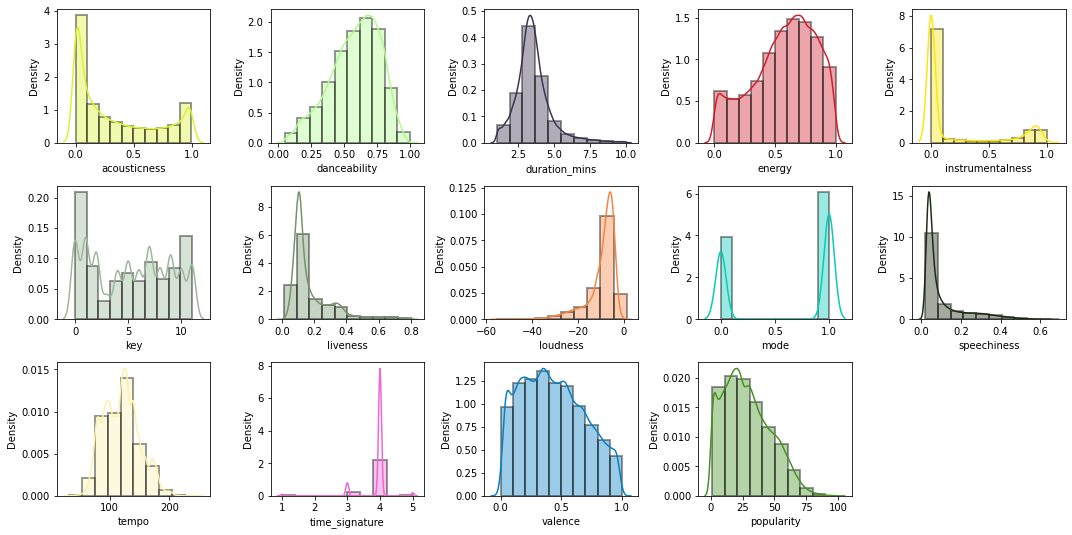

In [ ]:
print('\033[1mNumeric Features Distribution'.center(100))

n = 5
cols = audiodf.columns.tolist()[3:]
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(audiodf[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

*Remark*:
We can observe from the above plots that,

1. **Acousicness** has values that range from 0.0 to 1.0, but most values lie near 0. The songs with high acousticness consist of classical or folk music.

2. **Danceability** has values from 0.0 to 1.0, and we see that most values lie around 0.7, with a small percent of values towards the extreme ends(0 and 1)

3. **Duration_mins** takes values from 1.0 to 10.0, and we can see that most songs range from 3 to 4 minutes.

 **Energy** consists of values from 0.0 to 1.0, and we see that the density of songs with energy less than 0.5 is very less.

4. **Instrumentalness** has values from 0.0 to 1.0. This variable predicts if a song has vocals(Lower the value, higher the chance of vocals) and we see that, most songs have a value near 0, which means most songs have a presence of vocal component in them.

5. **Key** has values from 0 to 12, with values 0 for *C* and 12 for *B*.We can see that most songs are in the keys of *C#* and *C*

6. **Liveness** contains values from 0.0 to 1.0, with higher values meaning more chances of presence of audience in the recording. We see that most songs have a liveness near 0.0, and we will clean our data and remove songs, which can be live performances.

7. **Loudness** has values from 0.0 to 1.0, and we can see most songs have a loudness of around -10dB. Here 0dB is the normal standard for human hearing.

8. **Mode** has 2 values 0 and 1. We see that most songs have a happy tone in them, as they are in the major mode(mode=1), which is usually happy sounding(Except for some)

9. **Speechiness** has values from 0.0 to 1.0, and we can see that most songs have a speechiness of less than 0.25, also we clean out songs with speechiness of more than 0.66, as usually they would be podcasts, intro/outro tracks, and live performances.

10. **Tempo** mostly contains vales between 100 and 250, and we can see that the statistical mode for tempo is around 125, as people can enjoy the track rhythmically the most with the tempo around 120-130. 

11. **Time Signature** contains values 1.0 to 5.0 and wee see that most songs have a value of 4.0, which is vital for a song to gain much fan following as it is a universal rhythmic pattern.

12. **Valence** has values from 0.0 to 1.0, and we can see that most songs have a valence of less than 0.5, which indices a lesser tone happiness in most songs. We can make sense out of this pattern as the most popular key-mode pair from above plots, *C#major* or *Dbmajor*, usually represant a tone of grief or sadness.

13. **Popularity** takes values from 0.0 to 100.0, and we can see that there are only a few number of songs which are very popular, and there are a lot of tracks which go unheard.

In [ ]:
top_20_songs = audiodf.sort_values('popularity', ascending = False).copy().head(20)

                                 Numeric Features Distribution                                  


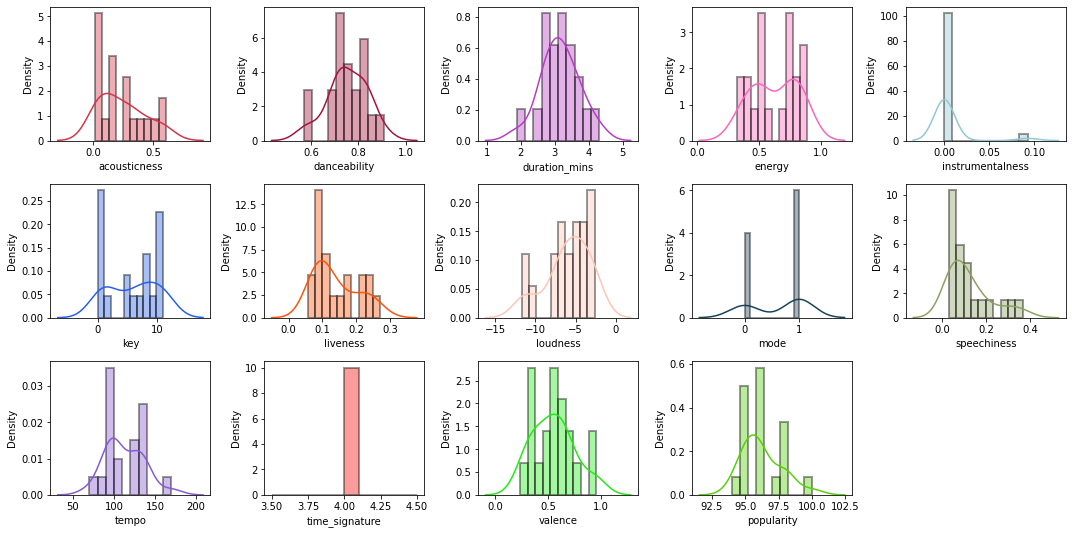

In [ ]:
print('\033[1mNumeric Features Distribution'.center(100))

n = 5
cols = top_20_songs.columns.tolist()[3:]
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(top_20_songs[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

*Remark*:
We can see from the above data that the top popular songs have,

1. Time Signature: The same time signature of 4, people enjoy rhythmic patterns that they are used to, as 4 is the most universal time signature.

2. Instrumentalness: People tend to listen songs with instrumentalness of value around 0 i.e. people enjoy vocals/lyrical presence than instrumental presence.

3. Key: The most popular songs are seen for key are C,C#, G#, B. Intuitive this make sense as B major has a relative minor of G# minor and both modes sound alike.

4. Dancability: Most popular songs have dancability score of around 0.75-0.85. People listen to more hype music.

5. Loudness (in scale of log2): Popular songs tend to have loudness in the range of -7 to -2 while a normal song on average have loudness in the range of -10 to -5. Popular songs tend to have more compression than an average song.

6. Duration: Most popular songs have duration of close to 2.5 mins, this tend to mean that people have less attention span while listening to music or doing anything.

7. Valence: As opposed to an average song, majority of popular songs tend to be more happy sounding, i.e. having a valence of over 0.35, so we see that the most popular songs are usually happy-toned.

8. Accousticness: People generally tend to listen to highly electrical music as opposed to clean accoustic tones like classical piece.

9. Energy: High Energy genres like metal and EDM do not usually show up in popular music.

10. Liveness: People tend to listen more to clean and compressed songs in comparison to distorted audio.

11. Tempo: Most popular song tend to have tempo less than 150 and more concentrated towards 100.

## Top 20 artist who have the highest average popularity amongst their songs

In [ ]:
audiodf.groupby('artist_name')['popularity'].mean().sort_values(ascending = False).head(20)

artist_name
Jonas Brothers         91.000000
Don Patricio           86.000000
Guaynaa                84.000000
Rammstein              84.000000
Paloma Mami            82.333333
DJ Luian               81.333333
MC Kevin o Chris       81.000000
PDL                    81.000000
Lil Dicky              81.000000
Louis Tomlinson        81.000000
Lil Nas X              81.000000
XO Cupid               81.000000
MC L da Vinte          81.000000
Tame Impala            80.000000
Daddy Yankee           79.833333
K/DA                   79.000000
JENNIE                 79.000000
I Belong to the Zoo    79.000000
Yo Gotti               79.000000
juan karlos            79.000000
Name: popularity, dtype: float64

In [ ]:
audiodf[audiodf.artist_name=='Drake']

,artist_name,track_id,track_name,acousticness,danceability,duration_mins,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
621,Drake,3mvYQKm8h6M5K5h0nVPY9S,After Dark (feat. Static Major &amp; Ty Dolla ...,0.04140,0.686,4.826000,0.428,0.000000,2,0.1380,-13.072,1,0.1920,141.950,4,0.3290,71
28647,Drake,585WOLp72ZY8LV88cMl4Lx,25 Flights,0.00181,0.657,3.151033,0.658,0.492000,5,0.1460,-12.785,0,0.0463,126.987,4,0.5550,1
93822,Drake,1v24T2ug4TlssYZvI3aL4O,Lust for Life,0.94200,0.507,2.936317,0.438,0.031300,6,0.1080,-10.318,1,0.1760,87.400,4,0.1090,69
93823,Drake,2TWSilrWcTrgVKcP8kfEfg,Unstoppable (Remix - feat. Santo Gold & Lil Wa...,0.17600,0.777,3.499283,0.914,0.000000,10,0.7180,-2.766,1,0.3190,150.061,4,0.8280,65
93824,Drake,6hHKFReuQR9VQp39ev43wY,The Outro,0.98800,0.399,2.906633,0.070,0.780000,5,0.3470,-21.523,1,0.0495,181.247,4,0.1330,61
94775,Drake,3SnXwQUrvSacFziUYXTNKY,Congratulations,0.01850,0.333,5.542167,0.859,0.000000,6,0.2200,-2.286,1,0.1480,86.882,5,0.1250,64
96851,Drake,0JaVdpmiex2EP7bBzyKVTa,November 18th,0.57900,0.749,3.136483,0.476,0.000000,11,0.1000,-11.147,0,0.5070,71.937,4,0.5340,69
96862,Drake,524wvipGqxPKYWxkjf9y46,Little Bit (feat. Lykke Li),0.09990,0.758,3.841400,0.888,0.033600,11,0.6610,-4.899,0,0.0374,120.392,4,0.7710,66
96910,Drake,4XTXamS1g4g93jPxyuFJJ6,Brand New,0.63100,0.399,3.558200,0.491,0.000000,6,0.1710,-8.992,1,0.0714,94.542,3,0.3560,63
98621,Drake,0q7LGcVSpsIoSbjChtZ8lI,Uptown (feat. Bun B & Lil Wayne),0.00391,0.416,6.371033,0.824,0.000000,1,0.1040,-3.075,1,0.3430,85.433,5,0.4170,68


*Remark*:
**We can see that Drake has a lower average popularity, as some of his tracks are lower in popularity, even though a couple of his tracks are very popular**

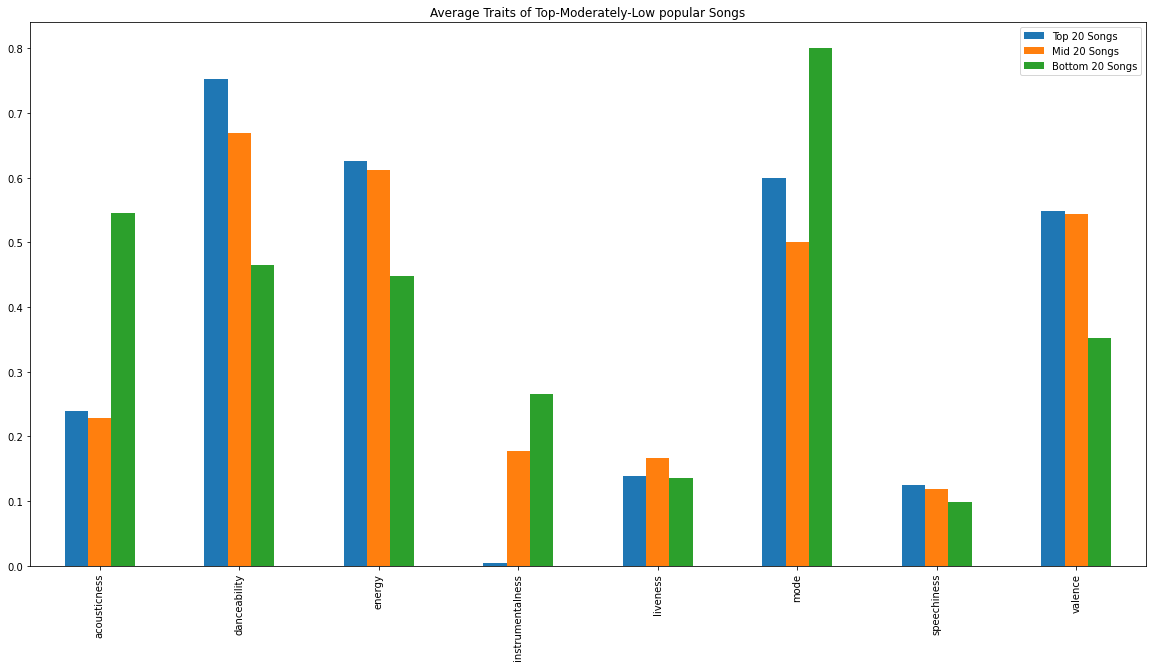

In [ ]:
check = audiodf[audiodf['popularity'].between(audiodf['popularity'].quantile(0.45),audiodf['popularity'].quantile(0.55))]
check = check[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']].head(20)
check = check.T
mid_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Mid 20 Songs'])

check = audiodf.sort_values(by = 'popularity',ascending=False).head(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
top_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Top 20 Songs'])

check = audiodf.sort_values(by = 'popularity',ascending=False).tail(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
bottom_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Bottom 20 Songs'])

top_bottom = pd.concat([top_20,mid_20, bottom_20], axis = 1)

top_bottom.plot(title = 'Average Traits of Top-Moderately-Low popular Songs', figsize=(20,10),linewidth=2,kind = 'bar' )

## Compare numeric features between Top-10% most popular songs *Vs* average-10% songs

                  top10percentile  avg10percentile
acousticness                0.995           0.9910
danceability                0.715           0.6570
duration_mins               3.200           3.2000
energy                      0.579           0.8180
instrumentalness            0.000           0.0000
key                         1.000           1.0000
liveness                    0.111           0.1090
loudness                   -6.365          -5.5490
mode                        1.000           1.0000
speechiness                 0.040           0.0351
tempo                     100.003         129.9950
time_signature              4.000           4.0000
valence                     0.325           0.9620
AxesSubplot(0.125,0.125;0.775x0.755)


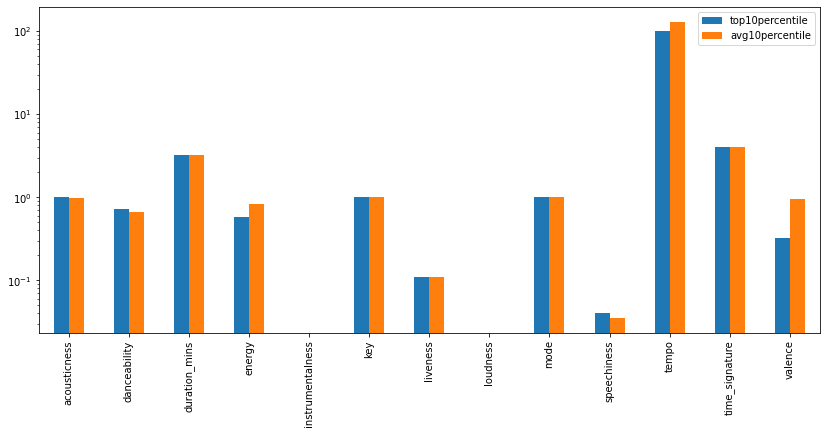

In [ ]:
top10 = np.percentile(audiodf.popularity.tolist(),90)
avg10low = np.percentile(audiodf.popularity.tolist(),45)
avg10high = np.percentile(audiodf.popularity.tolist(),55)

topdf = audiodf[audiodf.popularity>=top10].iloc[:,3:-1]
avgdf = audiodf[audiodf.popularity>=avg10low][audiodf.popularity<=avg10high].iloc[:,3:-1]

topdf = topdf.mode(axis = 0).iloc[0,:]
avgdf = avgdf.mode(axis = 0).iloc[0,:]

compdf = pd.concat([topdf,avgdf],axis = 1)
compdf.columns = ['top10percentile','avg10percentile']

print(compdf)

print(
    compdf.plot(
    kind="bar",
    logy = True,
    figsize = (14,6)
    )
)

## Correlation Heatplot for numeric variables

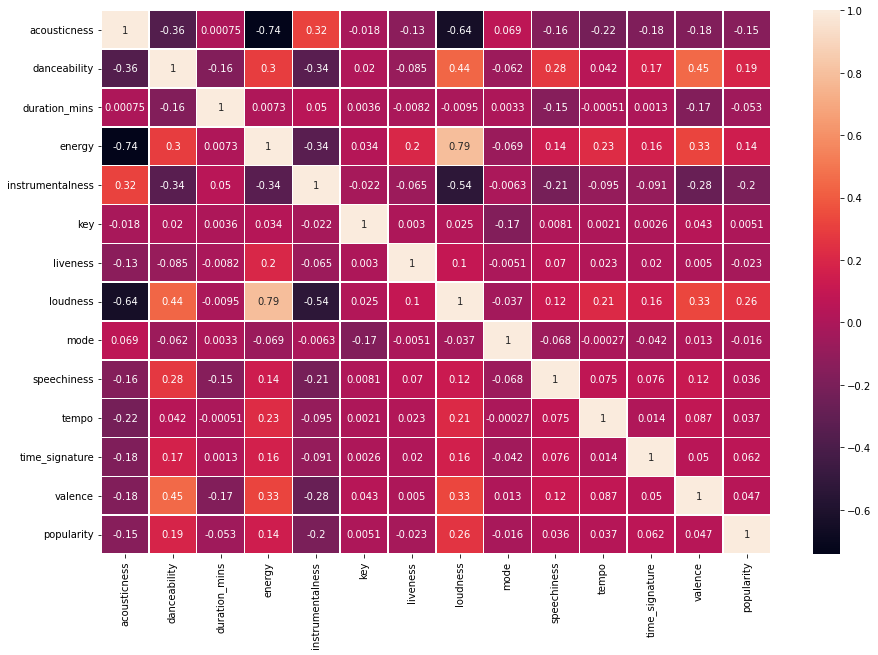

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))      
sns.heatmap(audiodf.corr(), annot=True,linewidths=.5, ax=ax)

*Remark*:
**We can observe that loudness is highly correlated with energy, instrumentalness and acousticness. Thus, We are removing loudness feature from the data.**

Text(0, 0.5, 'popularity')

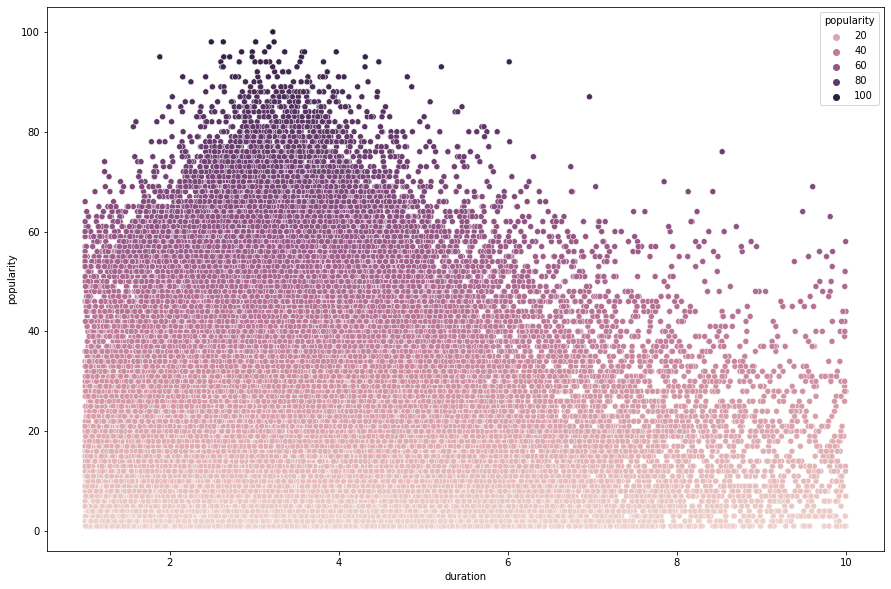

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=audiodf, x="duration_mins", y="popularity", hue="popularity"
)
plt.xlabel("duration")
plt.ylabel("popularity")

## Top 5 songs based on all song features

In [ ]:
int_float_cols=audiodf.select_dtypes(include=['float64','int64']).columns.tolist()
for i in int_float_cols:
    display(audiodf.nlargest(5, [i])[['artist_name','track_name',i]])

,artist_name,track_name,acousticness
793,Frédéric Chopin,"Waltz in D-Flat Major, Op. 70 No. 3 (Ed. J. Fo...",0.996
800,Frédéric Chopin,"Sostenuto in E-Flat Major, Op. Posth., B. 133",0.996
1384,Johann Sebastian Bach,"Goldberg Variations, BWV 988: Var. 19",0.996
1406,Johann Sebastian Bach,"The Well-Tempered Clavier, Book 1: Prelude & F...",0.996
1431,Johann Sebastian Bach,"The Well-Tempered Clavier, Book 1: Prelude & F...",0.996


,artist_name,track_name,danceability
35107,Louie Zong,Tappy Toes,0.996
66729,The Real Triple D,Paper Plates,0.986
68964,TÂCHES,Familiar Feeling,0.986
82694,Jean Tonique,No Worries,0.986
129853,ITSOKTOCRY,"POP, LOCK & DROPDEAD",0.985


,artist_name,track_name,duration_mins
104094,deadmau5,Monophobia - Extended Mix,10.000000
15575,Richard Wagner,"Der fliegende Holländer, WWV 63, Act II: Summ ...",9.999550
29356,Tangerine Dream,Non-Locality Destination,9.999550
108558,Johann Sebastian Bach,"Ouverture [No. 2] in B Minor, BWV 1067: I. Ouv...",9.997400
119684,Bethel Music,Reckless Love (Spontaneous),9.995767


,artist_name,track_name,energy
20384,Rain for Deep Sleep,"Winter Rain (Loopable, No Fade)",1.0
33289,Rain for Deep Sleep,Rainforest Heavy Shower,1.0
33316,Spa,Rain Sound: Tropical Forest,1.0
35408,Ocean Sounds,Ocean Hypnosis,1.0
36926,Zen Music Garden,"White Noise Rain(Loopable,No fade)",1.0


,artist_name,track_name,instrumentalness
27532,Looped Fan Sleep Noise,Pink Noise Sleeping Baby (All Night Looped),1.0
29989,Spa,Rain Sound: Relaxing Sleep Music,1.0
44981,Straight_bluffing,Taul Tor,1.0
68390,Rain Sounds,Gentle Thunderstorm,1.0
71870,Smoothed Brown Noise,The Brown Noise,1.0


,artist_name,track_name,key
48,Betty Who,Friend Like Me,11
59,Dominion,Balenciaga,11
85,Rub!k,Breathe Deep (ASOT 874),11
136,ARTY,Must Be The Love (ASOT 874),11
153,Rakeem Miles,Hardway,11


,artist_name,track_name,liveness
10126,PJ Morton,First Began - Live,0.799
25039,Wasback,Rise Again (feat. Drew Ryn),0.799
32507,Matthew Margeson,Olivia & Lucas,0.799
40036,Mrs. GREEN APPLE,PARTY,0.799
46888,Sho Baraka,Drowning (Last Sorry),0.799


,artist_name,track_name,loudness
23628,araabMUZIK,Lalalala,1.187
69302,Mefjus,Together,0.738
40698,Subtronics,Thermal Expansion,0.681
91625,Jarvis,Ready 2 Party,0.679
8350,Duki,Rockstar,0.642


,artist_name,track_name,mode
0,YG,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",1
45,Burbank,Waiting for U,1
46,PJ Lucid,Martyr Luther King,1
48,Betty Who,Friend Like Me,1
49,Your Smith,The Spot,1


,artist_name,track_name,speechiness
56603,Robbioso,Life That I Live (feat. Lil Ant),0.659
69299,Mefjus,Fractured,0.659
71593,Trapandy,Smoking Dope with the Zombie Clique,0.659
77673,Amazon Sounds,Recordings of the Amazon,0.659
70554,Amazon Sounds,Bird Recordings,0.658


,artist_name,track_name,tempo
62979,Dj Cappo,Money Lift,248.321
116275,Hola Amigos,Mojo,246.055
11007,DRWN.,Libra,245.379
129458,Juan Rios,Capitano (Instrumental Version),245.327
5101,Hypnotize,Komakatapult - Instrumental,241.234


,artist_name,track_name,time_signature
47,Messiah,Bien De To,5
94,Xavier Wulf,A Day's Routine - Interlude,5
165,Ne-Yo,OCEAN SURE,5
463,I Do,Woke Up In Kingston,5
510,BluntOne,Ghost Train Haze,5


,artist_name,track_name,valence
6785,Paperfiends,Hear a Prayer for Em,1.000
38166,Paperfiends,Bro Bro Get Along,1.000
46670,Jim Rystron,Rickett's,1.000
93813,Pierce,Reality Resonance,1.000
46672,Jim Rystron,"Run, Johnny, Run",0.994


,artist_name,track_name,popularity
99354,Daddy Yankee,Con Calma,100
99325,Post Malone,Wow.,98
99327,Jonas Brothers,Sucker,98
99329,Billie Eilish,bad guy,98
123704,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,98


**Bottom 5 sonngs based on song features**

In [ ]:
int_float_cols=audiodf.select_dtypes(include=['float64','int64']).columns.tolist()
for i in int_float_cols:
    display(audiodf.nsmallest(5, [i])[['artist_name','track_name',i]])

,artist_name,track_name,acousticness
17147,The Tibia Band.,I Don't Wanna Be Discarded ( Rag Bag),0.0
28804,RichaadEB,Lunar Clock Luna Dial,0.0
38698,Gatecreeper,Daybreak,0.0
40455,DJ Duro Flex,What the Feel,0.0
41006,RichaadEB,Beloved Tomboyish Daughter,0.0


,artist_name,track_name,danceability
32083,Mammoth Grinder,Superior Firepower,0.0513
31029,Zeke,AR-15,0.0516
79388,Steven Halpern,Ruby Crystal 2.0,0.0533
76538,TakumaDemonReborn,School,0.0550
84166,Sounds of Thunder and Rain,Sounds of Thunder,0.0555


,artist_name,track_name,duration_mins
136,ARTY,Must Be The Love (ASOT 874),1.0
4774,David Chief,meditation,1.0
6109,Two Sleepy,untitled,1.0
18890,Ocean Sounds,Wave Sound 1 - Loopable With No Fade,1.0
29157,Ramsie,Happy Birthday Ramsie,1.0


,artist_name,track_name,energy
30309,Silent Knights,Brown Noise Fan,0.000020
75411,Steven Halpern,Practitioner's Bowl 2.0,0.000020
79388,Steven Halpern,Ruby Crystal 2.0,0.000032
77428,Steven Halpern,Egyptian Blue Infinity 2.0,0.000053
110448,Max Richter,A Blank Canvas,0.000091


,artist_name,track_name,instrumentalness
0,YG,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.0
2,R3HAB,Radio Silence,0.0
42,Orjan Nilsen,Nothing Here But Love,0.0
47,Messiah,Bien De To,0.0
52,Money Man,Bday Cake,0.0


,artist_name,track_name,key
55,Tabi Bonney,Faded,0
56,Trevor Hall,Free,0
77,ARTY,Sunrise (ASOT 874),0
90,Alex Sonata,I'll Be Your Light (ASOT 874),0
93,Andy Moor,There Is Light (ASOT 874) - A.R.D.I. Remix,0


,artist_name,track_name,liveness
68781,Ленинград,Не Париж 2,0.0113
27434,Black Caviar,Coco - Wuki Remix,0.0118
21807,Friendly Fires,Love Like Waves - Alex Metric Remix,0.0131
30587,Ленинград,Заебуль,0.0138
53137,Julius Dreisig,In My Head,0.0148


,artist_name,track_name,loudness
44979,Straight_bluffing,Got Last Dean,-55.909
44980,Straight_bluffing,Hunsum Best,-54.574
69233,Rain Sounds,Storms Brewing,-53.280
64675,Rain Sounds,English Countryside,-51.800
52767,Baby Sleep Lullaby Academy,A Storm Approaches,-50.735


,artist_name,track_name,mode
2,R3HAB,Radio Silence,0
41,Mr Little Jeans,Forgetter,0
42,Orjan Nilsen,Nothing Here But Love,0
47,Messiah,Bien De To,0
51,Dirty Projectors,Blue Bird,0


,artist_name,track_name,speechiness
22112,The Greatest Bits,Astral Alley,0.0221
104093,José Pardial,Mañana,0.0224
89119,Adam Ackerman,Don't Worry About Me,0.0225
115374,Fleetwood Mac,Love Shines - Remastered,0.0226
114567,Eagles,Do Something,0.0227


,artist_name,track_name,tempo
39321,Dog Music,Amazing Dog Music,31.847
10603,The Album Leaf,Bottom of the Lake,32.001
65909,The Venus Project,Moon to Moon,32.095
62958,Sparkles of Fantasy,Fate in Love,33.003
64274,Sparkles of Fantasy,Wet Forest,33.108


,artist_name,track_name,time_signature
208,Twice 20,Fallin' - GET FAR Remix,1
298,Prelow,Some Nights,1
351,Johann Sebastian Bach,"Keyboard Concerto in D Minor, BWV 1059 (Arr. D...",1
768,Grupo Codiciado,El Jacal,1
784,Frédéric Chopin,"3 Grandes valses brillantes, Op. 34: No. 1 in ...",1


,artist_name,track_name,valence
69422,Daniel Pemberton,Molly's Dream,0.0
73400,dné,School,0.0
75411,Steven Halpern,Practitioner's Bowl 2.0,0.0
81542,dné,Work,0.0
86097,Rain Sound Studio,Bedtime Rain Recording,0.0


,artist_name,track_name,popularity
171,Chris Lane,Number One,1
252,Joe,Red Planet - Red Planet Extended,1
258,Young Fredo,Keep It Real,1
263,James Horner,"Jake's First Flight (From ""Avatar"")",1
276,RVSSLL,Tech House Rewind - JackEL Remix,1


Box plots for song features

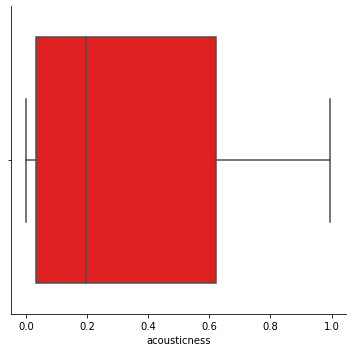

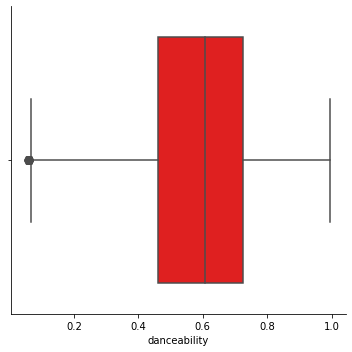

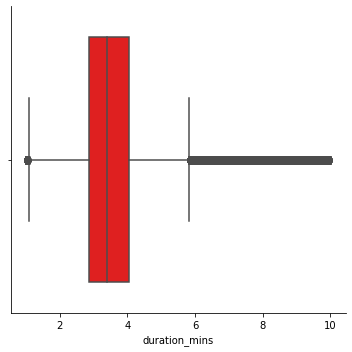

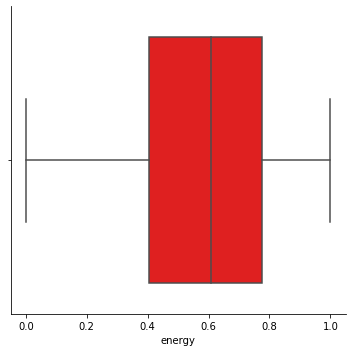

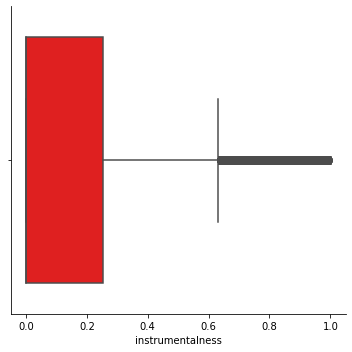

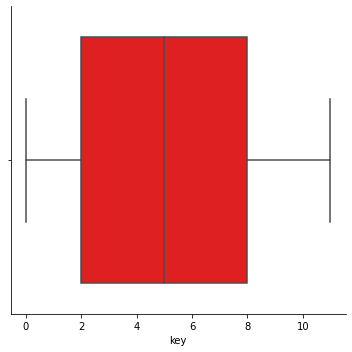

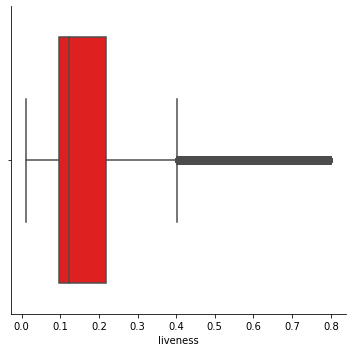

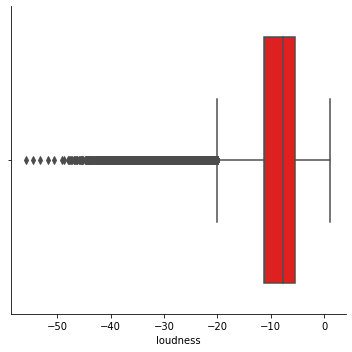

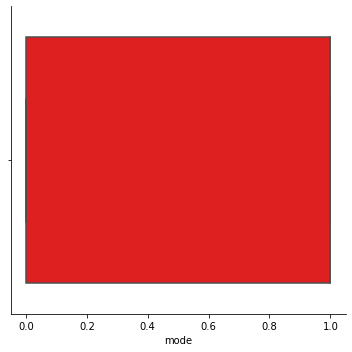

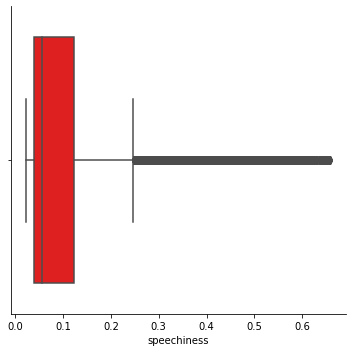

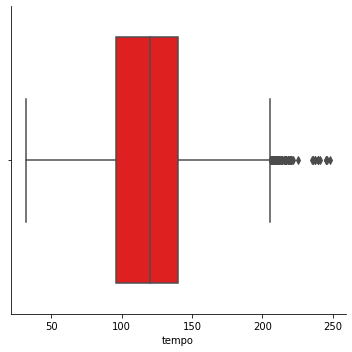

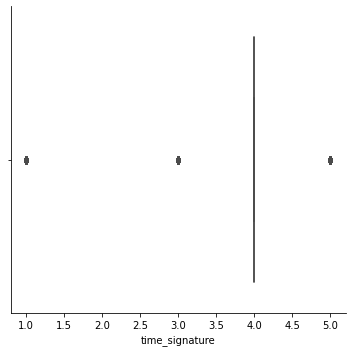

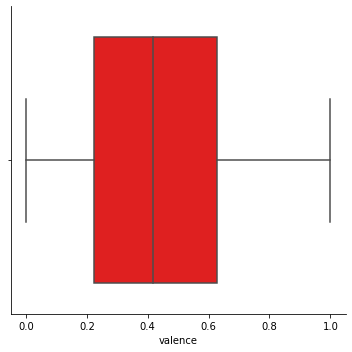

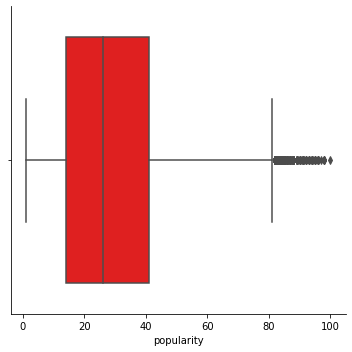

In [ ]:
for i in audiodf.columns.tolist()[3:]:
    sns.catplot(x = i, kind= 'box', data=audiodf, color = 'red')

In [ ]:
audiodf[audiodf.track_name.str.contains('mix|rain|podcast|intro|outro|DJ|sleep',
                                        re.IGNORECASE,
                                        regex = True)]

,artist_name,track_id,track_name,acousticness,danceability,duration_mins,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
62,Kiana Ledé,2PQVLVJ1J57t7uQO4Y2Mzq,Fairplay (feat. ASAP Ferg) - Remix,0.539000,0.733,2.798667,0.489,0.000190,8,0.102,-9.538,1,0.3060,139.949,4,0.6890,2
84,Vincent de Moor,6CHzMqs0evRZb9bczFWnyM,Fly Away (ASOT 874) - KhoMha Remix,0.000195,0.471,3.198833,0.888,0.893000,1,0.688,-11.833,1,0.0519,130.074,4,0.3040,18
93,Andy Moor,7BOPIDwfcZxrijQsmmIJNm,There Is Light (ASOT 874) - A.R.D.I. Remix,0.000170,0.454,4.202500,0.966,0.715000,0,0.477,-11.679,0,0.2400,137.035,4,0.0536,16
98,MaRLo,6d4kE5Kz6ZD4XNrItzdG2m,Haunted (ASOT 874) - Avao Remix,0.000977,0.499,4.059000,0.722,0.515000,7,0.331,-11.550,1,0.0429,136.174,4,0.0844,17
111,Armin van Buuren,6YAL6PEqjMuZQ7KTLD8W4q,We Control The Sunlight (ASOT 874) - Dan Stone...,0.000013,0.418,3.924167,0.860,0.465000,6,0.224,-11.502,0,0.0735,137.866,4,0.2060,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130212,DROELOE,5oGya0eMHo4sN1GqdO67fK,The First Wish - Flaws Remix,0.410000,0.681,3.922217,0.487,0.900000,0,0.140,-10.476,1,0.0347,89.999,4,0.2150,18
130287,A-Trak,2z1osTeSqdOOdfDZy025yY,DJs Gotta Dance More - Illyus & Barrientos Remix,0.000585,0.775,5.468117,0.820,0.114000,7,0.204,-5.313,1,0.0949,123.001,4,0.6490,42
130297,Joji,1n8KCrv2wq43ysd6HQCpV6,Will He (Ryan Hemsworth Remix),0.828000,0.533,2.803150,0.384,0.008490,2,0.118,-10.371,0,0.0394,126.570,4,0.3270,52
130304,BTS,6Tai2owBuWHcNXD00mQZi5,FAKE LOVE - Japanese ver. / Remix,0.032000,0.558,4.107550,0.762,0.000000,2,0.283,-4.148,0,0.0604,154.875,4,0.3700,50


# Feature Engineering

## Checking multicollinearity before feature engineering

In [ ]:

X = audiodf.iloc[:, 3:-1]
y = audiodf[['popularity']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

             feature        VIF
0       acousticness   4.195411
1       danceability  16.119820
2      duration_mins   9.062237
3             energy  19.294709
4   instrumentalness   2.059077
5                key   3.169078
6           liveness   2.941235
7           loudness   9.700250
8               mode   2.604339
9        speechiness   2.243469
10             tempo  16.335324
11    time_signature  49.710719
12           valence   5.675785


**Insights:**

1. Multicollinearity is significant in the data.
2. Daneability, energy , tempo and time signature have high VIF values which needs to be treated.


## Create new variables for our model
1. **Total songs by artists** : Number of songs by a given artist
2. **Is_new_artist** : Binary 0 or 1, depending on whether the artist is a new artist
3. **Popular_key** : Binary 0 or 1, depending on if the song is in a popular key(C, C#, G# or B) or not
4. **Noise_level** : We will get the difference between energy of a song and its acousticness and will scale it by 0.5, we will also drop energy and acousticness to prevent multicollinearity

In [ ]:

songs_grp = audiodf.groupby(['artist_name'])['track_id'].count().reset_index()
songs_grp = songs_grp.rename({'track_id':'total_songs_by_artist'}, axis = 'columns')

songs_grp['is_new_artist'] = np.where(songs_grp['total_songs_by_artist']==1,1,0)
audiodf = audiodf.merge(songs_grp, on = ['artist_name'], how = 'left')

audiodf['popular_key'] = np.where(audiodf['key'].isin([0.0, 1.0, 8.0, 11.0]), 1, 0) 

# Difference of accousticness and energy gives us noise levels.
audiodf['noise_level'] = (audiodf['energy'] - audiodf['acousticness']) / 2

## Checking multicollinearity after feature engineering

In [ ]:
X = audiodf[['duration_mins', 'instrumentalness', 
             'liveness', 'mode',
             'speechiness', 'tempo', 
             'valence','total_songs_by_artist', 
             'is_new_artist', 'popular_key', 
             'noise_level']]

y = audiodf[['popularity']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                  feature        VIF
0           duration_mins   6.797703
1        instrumentalness   1.566910
2                liveness   2.694030
3                    mode   2.508142
4             speechiness   2.036758
5                   tempo  10.628822
6                 valence   3.982557
7   total_songs_by_artist   1.277582
8           is_new_artist   1.196649
9             popular_key   1.619016
10            noise_level   1.685131


# Data Cleaning

## Drop rows or columns based on EDA

1. Based on Correlation Plot, Remove Loudness Variable

2. Drop track_names which has certain keywords pertaining to non-music tracks

3. Convert *tempo* variable into a categorical value where

> * Tempo less than 76 maps to -1 (Slow-tempo)

> * Tempo between 76 and 120 maps to 0 (Medium-tempo)

> * Tempo less than 76 maps to 1 (Up-tempo)


In [ ]:
## Remove loudness variable as it is highly correlated with certain other input variables

class Data_Cleaning_SP(object):
    def __init__(self, data = None, drop_columns = None, keywords = None, case_sensitive = False, is_cat_required = False, col_to_categorize=None, cat_low_cut_off = 0.5, cat_high_cut_off = 0.5):
        self.data = data
        self.drop_columns = drop_columns
        self.keywords = keywords
        self.case_sensitive = case_sensitive
        self.is_cat_required = is_cat_required
        self.col_to_categorize = col_to_categorize
        self.cat_low_cut_off = cat_low_cut_off
        self.cat_high_cut_off = cat_high_cut_off

    def drop_columns_from_df(self,drop_columns):
        """
        This function takes specific columns that we would like to drop out of our dataframe
        input   : a column OR a list of columns
        output  : the modified dataframe
        """
        if self.drop_columns:
            print("\n1. Drop columns engine started")

            if isinstance(drop_columns,list):
                print(f"\n Dropping columns: {','.join(drop_columns)}")
                self.data = self.data.drop(columns = drop_columns)
                
            elif isinstance(drop_columns,str):
                print(f"\n Dropping column {drop_columns}")
                self.data = self.data.drop(columns = drop_columns)
            
            print("\Columns Dropped")
        
        return self.data
    
    def regex_track_removal(self,keywords,case_sensitive):

        """
        This function takes specific keywords based on which we would like to drop certain track_names out of our dataframe
        input   : a regex-type input string
        output  : the modified dataframe
        """
        if self.keywords:
            print("\n2. Track_name removal based on regex started")
            if self.case_sensitive:
                _remove_ids = self.data[
                                    self.data.track_name.str.contains(
                                        pat = self.keywords,
                                        regex = True
                                    )
                                ].index
            else:
                _remove_ids = self.data[
                                    self.data.track_name.str.contains(
                                        pat = self.keywords,
                                        flags = re.IGNORECASE,
                                        regex = True
                                    )
                                ].index
            
            self.data = self.data.drop(index = _remove_ids)
            print("\nTrack_name removal based on regex done")
        
        return self.data
        
    def column_categorize(self, is_cat_required, col_to_categorize, cat_low_cut_off, cat_high_cut_off):
        """
        Categorize a column into a categorical variable based on provided cutoff
        """
        
        if is_cat_required and cat_low_cut_off and cat_high_cut_off:
            print(f"\n3. Column categorication for {col_to_categorize} started")
        
        #   self.data[col_to_categorize] = np.where(self.data[col_to_categorize]<cat_cut_off, 1, 0)
            self.data.loc[self.data[col_to_categorize].between(0,cat_low_cut_off-1),col_to_categorize] = -1
            self.data.loc[self.data[col_to_categorize].between(cat_low_cut_off,cat_high_cut_off),col_to_categorize] = 0
            self.data.loc[self.data[col_to_categorize] > cat_high_cut_off,col_to_categorize] = 1
            print(f"\n Column categorication for {col_to_categorize} done")
        
        return self.data


    def runner(self):
        print("=====Data Cleaning Pipeline started====")
        print("Dropping given list of columns")

        self.data = self.drop_columns_from_df(self.drop_columns)

        print("Regex removal from track name")
        self.data = self.regex_track_removal(self.keywords,self.case_sensitive)

        print("Applying column binning on given colums")
        self.data = self.column_categorize(self.is_cat_required, self.col_to_categorize, self.cat_low_cut_off, self.cat_high_cut_off)

        print("\n=====Data Cleaning Pipeline done====")
        return self.data

In [ ]:
audiodf = Data_Cleaning_SP(
data = audiodf,
drop_columns = ['loudness', 'danceability', 'time_signature', 'key', 'acousticness', 'energy'],
keywords = 'mix|rain|podcast|intro|outro|DJ|sleep',
case_sensitive = False,
is_cat_required = True,
col_to_categorize = 'tempo',
cat_low_cut_off = 76,
cat_high_cut_off = 120,
).runner()

=====Data Cleaning Pipeline started====
Dropping given list of columns

1. Drop columns engine started

 Dropping columns: loudness,danceability,time_signature,key,acousticness,energy
\Columns Dropped
Regex removal from track name

2. Track_name removal based on regex started

Track_name removal based on regex done
Applying column binning on given colums

3. Column categorication for tempo started

 Column categorication for tempo done

=====Data Cleaning Pipeline done====


## Checking multicollinearity after data cleaning

In [ ]:
X = audiodf[['duration_mins', 'instrumentalness', 
             'liveness', 'mode',
             'speechiness', 'tempo', 
             'valence','total_songs_by_artist', 
             'is_new_artist', 'popular_key', 
             'noise_level']]

y = audiodf[['popularity']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                  feature       VIF
0           duration_mins  4.639523
1        instrumentalness  1.497975
2                liveness  2.642208
3                    mode  2.445315
4             speechiness  1.922700
5                   tempo  1.024701
6                 valence  3.462092
7   total_songs_by_artist  1.288535
8           is_new_artist  1.194399
9             popular_key  1.601369
10            noise_level  1.646251


In [ ]:
vif_data

,feature,VIF
0,duration_mins,4.639523
1,instrumentalness,1.497975
2,liveness,2.642208
3,mode,2.445315
4,speechiness,1.922700
5,tempo,1.024701
6,valence,3.462092
7,total_songs_by_artist,1.288535
8,is_new_artist,1.194399
9,popular_key,1.601369


1. Create the buckets for acousticness - <0.5, 0 ; >0.5, 1
2. Drop time_signature.

In [ ]:
audiodf.describe()

,duration_mins,instrumentalness,liveness,mode,speechiness,tempo,valence,popularity,total_songs_by_artist,is_new_artist,popular_key,noise_level
count,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000,98446.000000
mean,3.538771,0.195615,0.177847,0.613067,0.106302,1.156091,0.440104,28.773053,127.318286,0.158219,0.380838,0.109837
std,1.235329,0.342219,0.134341,0.487051,0.109806,7.204873,0.253744,18.525553,511.744935,0.364948,0.485595,0.280844
min,1.000000,0.000000,0.011300,0.000000,0.022100,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-0.497886
25%,2.845875,0.000000,0.096800,0.000000,0.038400,0.000000,0.229000,14.000000,3.000000,0.000000,0.000000,-0.087000
50%,3.402792,0.000066,0.121000,1.000000,0.054700,1.000000,0.420000,26.000000,10.000000,0.000000,0.000000,0.195500
75%,4.018217,0.203000,0.215000,1.000000,0.124000,1.000000,0.633000,42.000000,19.000000,0.000000,1.000000,0.331000
max,9.999550,1.000000,0.799000,1.000000,0.659000,75.999000,1.000000,100.000000,2900.000000,1.000000,1.000000,0.498997


# Modeling

### Define X(input) and y(target) sets

In [ ]:
X = audiodf[['duration_mins', 'instrumentalness', 
             'liveness', 'mode',
             'speechiness', 'tempo', 
             'valence','total_songs_by_artist', 
             'is_new_artist', 'popular_key', 
             'noise_level']].copy()
X['duration_mins'] = np.log(X['duration_mins'])
#X['key'] = np.log(X['key'])
y = audiodf[['popularity']]

## Vanilla OLS model

### Model Performance check

In [ ]:
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:             popularity   R-squared (uncentered):                   0.694
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                          2.027e+04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                        0.00
Time:                        23:26:51   Log-Likelihood:                     -4.2924e+05
No. Observations:               98446   AIC:                                  8.585e+05
Df Residuals:                   98435   BIC:                                  8.586e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Check Q-Q plot for Normality

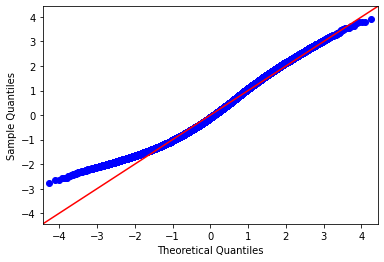

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

## OLS with log transformation on the y variable.

### Model Performance check

In [ ]:
#X = sm.add_constant(X)
model = sm.OLS(np.log(y), X).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:             popularity   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                          6.497e+04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                        0.00
Time:                        23:26:53   Log-Likelihood:                     -1.4989e+05
No. Observations:               98446   AIC:                                  2.998e+05
Df Residuals:                   98435   BIC:                                  2.999e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Check Q-Q plot for Normality

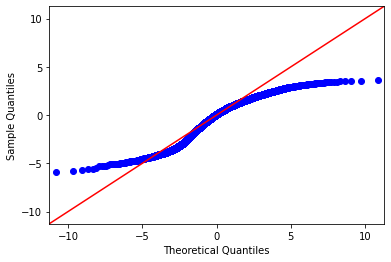

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

Insights: The qq plot became even more distorted. Hence lets try box cox transformation:

In [ ]:
audiodf.columns

Index(['artist_name', 'track_id', 'track_name', 'duration_mins',
       'instrumentalness', 'liveness', 'mode', 'speechiness', 'tempo',
       'valence', 'popularity', 'total_songs_by_artist', 'is_new_artist',
       'popular_key', 'noise_level'],
      dtype='object')

## OLS model with Box-Cox transformation on y variable

### Model Performance check

In [ ]:
# Applying box-cox transformation
yt, _ = stats.boxcox(y['popularity'].values)
model = sm.OLS(yt, X).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.789
Model:                            OLS   Adj. R-squared (uncentered):              0.789
Method:                 Least Squares   F-statistic:                          3.356e+04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                        0.00
Time:                        23:26:56   Log-Likelihood:                     -2.8861e+05
No. Observations:               98446   AIC:                                  5.772e+05
Df Residuals:                   98435   BIC:                                  5.773e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Check Q-Q plot for Normality

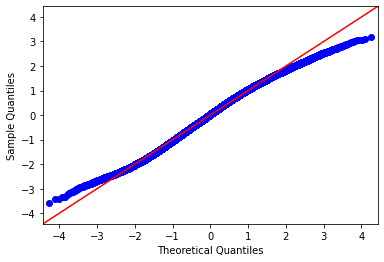

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.figure()
plt.show()

## Remarks from above experiments

We see from the above results, that we get the best results for the OLS with box-cox transformation on y variable gives us the best normality on Q-Q plot, and we will use the same model to test for *RMSE* on our test set

## Split our data into train and test sets and check RMSE on test set

### Train-test split

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(
    X, yt , test_size=0.15, random_state=1000)

### Model Performance check

In [ ]:
model = sm.OLS(y_train, X_train).fit()
res = model.resid
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.789
Model:                            OLS   Adj. R-squared (uncentered):              0.789
Method:                 Least Squares   F-statistic:                          2.852e+04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                        0.00
Time:                        23:26:58   Log-Likelihood:                     -2.4538e+05
No. Observations:               83679   AIC:                                  4.908e+05
Df Residuals:                   83668   BIC:                                  4.909e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

###Test set RMSE

In [ ]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

4.519119231300295

# Hypothesis Testing

## 1. Songs in Major mode are more popular than ones in minor

> H<sub>0</sub>: $\beta$<sub>mode</sub> <= 0


> H<sub>1</sub>:
$\beta$<sub>mode</sub> > 0




*Remark:* We see from our model that, our p-value is very high, hence we FAIL to reject our null hypothesis, and conclude that based on our data, songs in minor mode are more popular.

## 2. For a song to be popular, we need it to be in a popular key

> H<sub>0</sub>: 
$\beta$<sub>popular_key</sub> <= 0

> H<sub>1</sub>: $\beta$<sub>popular_key</sub> > 0

We hypothesize that, for a song to be popular, it has to be in a key of *C*, *C#*, *G#*, *B* (with *key* values of 0,1,8,11 respectively)

*Remark:* We see from our model that, our p-value is very high, hence we FAIL to reject our null hypothesis, and conclude that based on our data, songs do not have to be in popular key to be popular.

## 3. Songs with high noise are most popular

> H<sub>0</sub>: $\beta$<sub>noise_level</sub> <= 0

> H<sub>1</sub>: $\beta$<sub>noise_level</sub> > 0

*Remark:* We see from our model that, our p-value is very high, hence we FAIL to reject our null hypothesis, and conclude that based on our data, songs with high noise are not the most pupular ones.

## 4. Most people like listening to songs of short duration.

> H<sub>0</sub>: 
$\beta$<sub>duration_mins</sub> >= 0

> H<sub>1</sub>: $\beta$<sub>duration_mins</sub> < 0

*Remark:* We see from our model that, our p-value is very low, hence we can reject our null hypothesis, and conclude that based on our data, the longer the duration of a song, the lesser its likelyhood of being popular.

## 5. An artist with a lot of songs is more popular than one with lesser number of  songs

> H<sub>0</sub>: 
$\beta$<sub>total_songs_by_artist</sub> <= 0

> H<sub>1</sub>: $\beta$<sub>total_songs_by_artist</sub> > 0

*Remark:* We see from our model that, our p-value is very high, hence we FAIL to reject our null hypothesis, and conclude that based on our data, an artist with more songs, is not necessarily always more popular

# Model Improvements

## Random Forest Regressor fit on our data

###Model Fit

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(
    X, yt , test_size=0.15, random_state=1000)

rf_model = RandomForestRegressor(max_depth=2, random_state=0)

rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=2, random_state=0)

###Test set RMSE

In [ ]:
y_hat = rf_model.predict(X_test)
mean_squared_error(y_test, y_hat, squared=False)

4.051562574457835

## Cat Boost Regressor with grid search

In [ ]:
cat_model = CatBoostRegressor(loss_function='RMSE',
                           verbose=True)

###Grid Search for best parameters

In [ ]:
grid = {'iterations': [5, 10, 50, 100],
        'learning_rate': [0.0001,0.001, 0.01],
        'depth': [1, 10, 50, 100],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

grid = GridSearchCV(
    estimator=cat_model, 
    param_grid = grid, 
    cv = 5, 
    n_jobs=-1
    )

grid.fit(X_train, y_train)

0:	learn: 4.2998098	total: 98.9ms	remaining: 9.79s
1:	learn: 4.2929229	total: 142ms	remaining: 6.97s
2:	learn: 4.2863628	total: 188ms	remaining: 6.09s
3:	learn: 4.2800066	total: 235ms	remaining: 5.64s
4:	learn: 4.2737795	total: 281ms	remaining: 5.34s
5:	learn: 4.2675192	total: 329ms	remaining: 5.16s
6:	learn: 4.2611377	total: 375ms	remaining: 4.98s
7:	learn: 4.2550598	total: 419ms	remaining: 4.82s
8:	learn: 4.2491940	total: 470ms	remaining: 4.75s
9:	learn: 4.2433348	total: 514ms	remaining: 4.62s
10:	learn: 4.2375855	total: 561ms	remaining: 4.54s
11:	learn: 4.2318943	total: 605ms	remaining: 4.43s
12:	learn: 4.2265075	total: 649ms	remaining: 4.34s
13:	learn: 4.2210298	total: 700ms	remaining: 4.3s
14:	learn: 4.2155816	total: 743ms	remaining: 4.21s
15:	learn: 4.2103635	total: 802ms	remaining: 4.21s
16:	learn: 4.2050154	total: 846ms	remaining: 4.13s
17:	learn: 4.1998240	total: 918ms	remaining: 4.18s
18:	learn: 4.1948782	total: 964ms	remaining: 4.11s
19:	learn: 4.1898573	total: 1.02s	remaini

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa3806645b0>,
             n_jobs=-1,
             param_grid={'depth': [1, 10, 50, 100],
                         'iterations': [5, 10, 50, 100],
                         'l2_leaf_reg': [0.2, 0.5, 1, 3],
                         'learning_rate': [0.0001, 0.001, 0.01]})

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.1486635503282216

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 0.2, 'learning_rate': 0.01}


*Remark:* We see that the best parameters are

> **{'depth': 10, 'iterations': 100, 'l2_leaf_reg': 0.2, 'learning_rate': 0.01}**

###Model Fit

In [ ]:
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=True,
    depth = 10,
    iterations = 1000,
    l2_leaf_reg =  0.2,
    learning_rate = 0.01
    )

cat_model.fit(X_train,y_train)

0:	learn: 4.2998098	total: 50.3ms	remaining: 50.2s
1:	learn: 4.2929229	total: 99.1ms	remaining: 49.4s
2:	learn: 4.2863628	total: 145ms	remaining: 48.2s
3:	learn: 4.2800066	total: 193ms	remaining: 48s
4:	learn: 4.2737795	total: 239ms	remaining: 47.5s
5:	learn: 4.2675192	total: 287ms	remaining: 47.6s
6:	learn: 4.2611377	total: 337ms	remaining: 47.8s
7:	learn: 4.2550598	total: 395ms	remaining: 49s
8:	learn: 4.2491940	total: 441ms	remaining: 48.5s
9:	learn: 4.2433348	total: 485ms	remaining: 48s
10:	learn: 4.2375855	total: 544ms	remaining: 49s
11:	learn: 4.2318943	total: 589ms	remaining: 48.5s
12:	learn: 4.2265075	total: 634ms	remaining: 48.1s
13:	learn: 4.2210298	total: 678ms	remaining: 47.8s
14:	learn: 4.2155816	total: 735ms	remaining: 48.3s
15:	learn: 4.2103635	total: 785ms	remaining: 48.3s
16:	learn: 4.2050154	total: 831ms	remaining: 48s
17:	learn: 4.1998240	total: 875ms	remaining: 47.7s
18:	learn: 4.1948782	total: 933ms	remaining: 48.2s
19:	learn: 4.1898573	total: 994ms	remaining: 48.7

###Test set RMSE

In [ ]:
y_hat = cat_model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_hat, squared=False))

RMSE: 3.80855293114443
